# ```Model Training and Evaluation with Undersampling```

Importing the required libraries

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from imblearn.under_sampling import CondensedNearestNeighbour,EditedNearestNeighbours,TomekLinks,NearMiss
from imblearn.under_sampling import OneSidedSelection, NeighbourhoodCleaningRule, RandomUnderSampler, InstanceHardnessThreshold, AllKNN
from matplotlib import pyplot
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier as CBC
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC 
from imblearn import under_sampling
from typing import Counter
from sklearn.metrics import classification_report
from matplotlib import legend
from matplotlib.colors import Colormap
from matplotlib.pyplot import bar_label
%matplotlib inline


In [3]:
# Surpress warnings:
# import warnings
# def warn(*args, **kwargs):
#     pass
# warnings.warn = warn

This function plots the confusion matrices given y_i, y_i_hat.

In [4]:
def plot_confusion_matrix(y, y_predict, t='Confusion Matrix', cm=None):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix
    if cm is None:
        cm = confusion_matrix(y, y_predict)
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(cm, annot=True, ax=ax, cmap='mako', fmt=',d').set_title(
        t, fontsize=12)
    # sns.color_palette("mako", as_cmap=True)
    ax.set_xlabel('Predicted labels', fontsize=10)
    ax.set_ylabel('True labels', fontsize=10)
    # ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    ax.yaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    plt.show()

This function plots the confusion matrices in a grid format given y_i, y_i_hat.

In [5]:
def plot_confusion_grid(y, y_predict, t='Confusion Matrix', cm=None):
    if cm is None:
        cm = confusion_matrix(y, y_predict)
    fig, axx = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    ust = ['ENN', 'NM', 'IHT', 'AKNN']
    k = 0
    for i in range(2):
        for j in range(2):
            sns.heatmap(cm[k], annot=True, ax=axx[i][j], cmap='mako', fmt=',d').set_title(f"{ust[k]} Undersampling", fontsize=12)
            axx[i][j].set_xlabel('Predicted labels', fontsize=10)
            axx[i][j].set_ylabel('True labels', fontsize=10)
            axx[i][j].xaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
            axx[i][j].yaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
            k += 1
    fig.suptitle(t, fontsize=16)
    plt.show()


In [6]:
# def plot_confusion_matrix(y, y_predict, t='Confusion Matrix', cm=None):
#     "this function plots the confusion matrix"
#     from sklearn.metrics import confusion_matrix
#     if cm is None:
#         cm = confusion_matrix(y, y_predict)
#     fig, (ax0, ax1, ax2) = plt.subplots(
#         nrows=1, ncols=3, sharex=False, figsize=(15, 4))
#     sns.heatmap(cm, annot=True, ax=ax0, cmap='mako', fmt=',d').set_title(
#         t, fontsize=12)
#     # sns.color_palette("mako", as_cmap=True)
#     ax0.set_xlabel('Predicted labels', fontsize=10)
#     ax0.set_ylabel('True labels', fontsize=10)
#     # ax.set_title('Confusion Matrix');
#     ax0.xaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
#     ax0.yaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
#     x = np.arange(0.1, 4, 0.1)
#     y1 = np.exp(-1.0 * x)
#     y2 = np.exp(-0.5 * x)
#     # example variable error bar values
#     y1err = 0.1 + 0.1 * np.sqrt(x)
#     y2err = 0.1 + 0.1 * np.sqrt(x/2)

#     ax1.set_title('only every 6th errorbar')
#     ax1.errorbar(x, y1, yerr=y1err, errorevery=6)
#     ax1.errorbar(x, y2, yerr=y2err, errorevery=6)

#     ax2.set_title('second series shifted by 3')
#     ax2.errorbar(x, y1, yerr=y1err, errorevery=(0, 6))
#     ax2.errorbar(x, y2, yerr=y2err, errorevery=(3, 6))

#     fig.suptitle('SUBPLOT TITLE', fontsize=16)
#     plt.show()


This function plots the confusion matrix, the scores and the roc auc curve for a given model.

In [7]:
def plot_graphs(y, y_predict, t='Confusion Matrix',cm=None, rep=None, yprob=None):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix
    if cm is None:
        cm = confusion_matrix(y, y_predict)
    fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(15, 4))
    sns.heatmap(cm, annot=True, ax=ax0, cmap='mako', fmt=',d').set_title(
        t, fontsize=12)
    # sns.color_palette("mako", as_cmap=True)
    ax0.set_xlabel('Predicted labels', fontsize=10)
    ax0.set_ylabel('True labels', fontsize=10)
    # ax.set_title('Confusion Matrix');
    ax0.xaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    ax0.yaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    x = np.arange(0.1, 4, 0.1)
    y1 = np.exp(-1.0 * x)
    y2 = np.exp(-0.5 * x)
    # example variable error bar values
    y1err = 0.1 + 0.1 * np.sqrt(x)
    y2err = 0.1 + 0.1 * np.sqrt(x/2)

    # ax1.set_title('only every 6th errorbar')
    # ax1.errorbar(x, y1, yerr=y1err, errorevery=6)
    # ax1.errorbar(x, y2, yerr=y2err, errorevery=6)
    # ax1.bar(rep)
    rep=rep.transpose()
    # rep.
    print(rep)
    # counts = [40, 100, 30, 55]
    # bar_labels = rep.columns
    # bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

    # ax1.bar(rep, label=bar_labels, color=bar_colors, height=0.5)
    bplot= rep.plot(kind='bar', ax=ax1, color="steelblue",legend=False)
    for bar in bplot.patches:

      # Using Matplotlib's annotate function and
      # passing the coordinates where the annotation shall be done
      # x-coordinate: bar.get_x() + bar.get_width() / 2
      # y-coordinate: bar.get_height()
      # free space to be left to make graph pleasing: (0, 8)
      # ha and va stand for the horizontal and vertical alignment
        bplot.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()-0.02), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

    ax1.set_ylabel('Metrics')
    ax1.set_title('Comparison')
    # ax1.legend(title='Model Eval')

    # plt.show()


    ax2.set_title('second series shifted by 3')
    ax2.errorbar(x, y1, yerr=y1err, errorevery=(0, 6))
    ax2.errorbar(x, y2, yerr=y2err, errorevery=(3, 6))

    fig.suptitle('SUBPLOT TITLE', fontsize=16)
    plt.show()

In [8]:
# plot_graphs(0,0,t='Confusion Matrix',cm=cmm[0])
# for i in cmm:
#     plot_confusion_matrix(0, 0, t='Confusion Matrix', cm=cmm[0])


This function plots the roc curve given y_i, y_i_prob.

In [9]:
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


This function prints the report for a given model, and returns a dataframe with the scores.

In [10]:
def report(yt, y_pred):
    d = {"Accuracy": accuracy_score(yt, y_pred),
         "Precision": precision_score(yt, y_pred),
         "Recall": recall_score(yt, y_pred),
         "F1 score": f1_score(yt, y_pred)}
    rep = pd.DataFrame(d, index=[0])
    print(rep)
    return rep

This function plots the bargraph of the scores for a given model trained using various undersampling techniques.

In [11]:
def resplot(res, title):
  bplot = res.plot(kind='bar', width=0.85, colormap='mako',
                     figsize=(13, 4), title=title, legend=False, fontsize=10)
  for bar in bplot.patches:
    bplot.annotate(format(bar.get_height(), '.2f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()-0.02), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
  bplot.legend(bbox_to_anchor=(1.0, 0.8), fontsize='medium')
  bplot.title.set_size(15)
  plt.xticks(rotation=0)
  plt.show()


This function returns a list of the scores for a given model trained using various undersampling techniques.

In [12]:
def report1(yt, y_pred):
    rep = [accuracy_score(yt, y_pred), precision_score(yt, y_pred),recall_score(yt, y_pred) ,f1_score(yt, y_pred)]
    # print(rep)
    return rep


Loading the datasets

In [13]:
df = pd.read_csv('train40Features.csv')
target = pd.read_csv('train.csv')

In [14]:
#adding target column to our train dataset
df['target'] = target['target']

In [15]:
df.drop('V1',axis = 1, inplace = True) 

In [79]:
#renamng columns
columns = ['sex','age','anatomy','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8','V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34','V35','V36','target']
df.columns = columns
# df.head()

In [17]:
# df.drop(['anatomy','sex', 'age'],axis = 1, inplace = True)

In [18]:
df['target'].value_counts()

target
0    32542
1      584
Name: count, dtype: int64

<h1> Undersampling Techniques </h1>

Dictionaries to store the training and testing data for each undersampling technique

In [19]:
x = {}
y = {} 
x_train = {} 
x_test = {} 
y_train = {} 
y_test = {}

### 1. Edited Nearest Neighbours Undersampling

In [20]:
# define the undersampling method
undersample = EditedNearestNeighbours(n_neighbors=200)
x['ENN'], y['ENN'] = undersample.fit_resample(df.drop('target',axis=1),df['target'])
y_under = pd.DataFrame(y['ENN'])
x_train['ENN'], x_test['ENN'], y_train['ENN'], y_test['ENN'] = train_test_split(x['ENN'], y['ENN'], 
                                                                                test_size=0.25, random_state=4)
print(y_train['ENN'].value_counts(),'\n',y_test['ENN'].value_counts())
st_x= StandardScaler()    
x_train['ENN']= st_x.fit_transform(x_train['ENN'])    
x_test['ENN']= st_x.transform(x_test['ENN']) 

target
0    4421
1     429
Name: count, dtype: int64 
 target
0    1462
1     155
Name: count, dtype: int64


#### Obseravtions:
* We can see that after ENN undersampling the data has been reduced to 4421+1462+429+155 = 6467 rows.
* 1:70 ratio has now been reduced to around 1:10 malignant:bengin ratio.

In [21]:
# # define the undersampling method
# undersample = TomekLinks(sampling_strategy='auto')
# # undersample.sampling_strategy_={0:2000, 1:584}
# # print(TomekLinks.set_params(sampling_strategy_= 'auto'))
# x['TL'], y['TL'] = undersample.fit_resample(df.drop('target',axis=1),df['target'])
# #splitting dataset into training and testing sets
# x_train['TL'], x_test['TL'], y_train['TL'], y_test['TL'] = train_test_split(x['TL'], y['TL'], 
#                                                                                 test_size=0.25, random_state=4)
# print(y_train['TL'].value_counts(),'\n',y_test['TL'].value_counts())
# #normalizing the data
# x_train['TL']= st_x.fit_transform(x_train['TL'])    
# x_test['TL']= st_x.transform(x_test['TL']) 

#### 2. ALLKNN Undersampling

In [22]:
from imblearn.under_sampling import AllKNN
undersample= AllKNN(n_jobs=-1, n_neighbors=65)
x['AKNN'], y['AKNN'] = undersample.fit_resample(df.drop('target',axis=1),df['target'])
x_train['AKNN'], x_test['AKNN'], y_train['AKNN'], y_test['AKNN'] = train_test_split(x['AKNN'], y['AKNN'], test_size=0.25, random_state=42)
print(y_train['AKNN'].value_counts(),'\n',y_test['AKNN'].value_counts())
st_x= StandardScaler()
x_train['AKNN']= st_x.fit_transform(x_train['AKNN'])
x_test['AKNN']= st_x.transform(x_test['AKNN'])

target
0    5860
1     432
Name: count, dtype: int64 
 target
0    1946
1     152
Name: count, dtype: int64


#### Observations:
* The data has been reduced to around ```1:15 malignant:bengin ratio.```

In [23]:
# undersample= OneSidedSelection(n_neighbors=20, n_seeds_S=1000)
# x['OSS'], y['OSS'] = undersample.fit_resample(df.drop('target',axis=1),df['target'])
# x_train['OSS'], x_test['OSS'], y_train['OSS'], y_test['OSS'] = train_test_split(x['OSS'], y['OSS'], test_size=0.25, random_state=42)
# print(y_train['OSS'].value_counts(),'\n',y_test['OSS'].value_counts())
# st_x= StandardScaler()
# x_train['OSS']= st_x.fit_transform(x_train['OSS'])
# x_test['OSS']= st_x.transform(x_test['OSS'])
#removed this, low accuracy

#### 3. NearMiss-1 Undersampling

In [24]:
undersample = NearMiss(version=1, sampling_strategy={0:2500, 1:584})
x['NM'], y['NM'] = undersample.fit_resample(df.drop('target',axis=1),df['target'])
x_train['NM'], x_test['NM'], y_train['NM'], y_test['NM'] = train_test_split(x['NM'], y['NM'], test_size=0.25, random_state=42)
print(y_train['NM'].value_counts(),'\n',y_test['NM'].value_counts())
st_x= StandardScaler()    
x_train['NM']= st_x.fit_transform(x_train['NM'])    
x_test['NM']= st_x.transform(x_test['NM']) 

target
0    1875
1     438
Name: count, dtype: int64 
 target
0    625
1    146
Name: count, dtype: int64


* Here the data is reduced to ```1:4 malignant:bengin ratio.```

#### 4. InstanceHardnessThreshold Undersampling

In [25]:
undersample= InstanceHardnessThreshold(sampling_strategy='auto', n_jobs=-1, estimator=DecisionTreeClassifier(max_depth=8))
x['IHT'], y['IHT']= undersample.fit_resample(df.drop('target',axis=1),df['target'])
x_train['IHT'], x_test['IHT'], y_train['IHT'], y_test['IHT'] = train_test_split(x['IHT'], y['IHT'], test_size=0.25, random_state=42)
print(y_train['IHT'].value_counts(),'\n',y_test['IHT'].value_counts())
st_x= StandardScaler()
x_train['IHT']= st_x.fit_transform(x_train['IHT'])
x_test['IHT']= st_x.transform(x_test['IHT'])

target
0    2276
1     442
Name: count, dtype: int64 
 target
0    765
1    142
Name: count, dtype: int64


* Here the data is reduced to ```1:5 malignant:benign ratio.```

In [26]:
# x_train['NM'].std(axis=0)


In [27]:
# # define the undersampling method
# undersample = ClusterCentroids(sampling_strategy='auto')
# # transform the dataset
# x['CC'], y['CC'] = undersample.fit_resample(df.drop('target',axis=1),df['target'])
# #converting label to dataframe
# y_under = pd.DataFrame(y['CC'])
# #splitting dataset into training and testing sets
# x_train['CC'], x_test['CC'], y_train['CC'], y_test['CC'] = train_test_split(x['CC'], y['CC'], 
#                                                                                 test_size=0.25, random_state=4)
# #finding the split of label values in the training and testing sets
# print(y_train['CC'].value_counts(),'\n',y_test['CC'].value_counts())
# #normalizing the data
# st_x= StandardScaler()    
# x_train['CC']= st_x.fit_transform(x_train['CC'])    
# x_test['CC']= st_x.transform(x_test['CC']) 

In [28]:
# from imblearn import under_sampling
# rus = under_sampling.RandomUnderSampler(
#     sampling_strategy={0:2000, 1:584})
# x['RUS'], y['RUS']= rus.fit_resample(df.drop('target',axis=1),df['target'])
# x_train['RUS'], x_test['RUS'], y_train['RUS'], y_test['RUS'] = train_test_split(x['RUS'], y['RUS'],
#                                                                             test_size=0.25, random_state=4)
# x_train['RUS'] = st_x.fit_transform(x_train['RUS'])
# x_test['RUS'] = st_x.transform(x_test['RUS'])
# print(Counter(y_train['RUS']), '\n', Counter(y_test['RUS']))


Printing the shape of the training and testing data and the class counts for each undersampling technique

In [29]:
ust = ['ENN', 'NM', 'IHT', 'AKNN']
for i in ust:
    print(i, x_train[i].shape, x_test[i].shape, y_train[i].shape, y_test[i].shape)
    print(Counter(y_train[i]), Counter(y_test[i]), "\n\n")
    # y_test['TL'].shape


ENN (4850, 39) (1617, 39) (4850,) (1617,)
Counter({0: 4421, 1: 429}) Counter({0: 1462, 1: 155}) 


NM (2313, 39) (771, 39) (2313,) (771,)
Counter({0: 1875, 1: 438}) Counter({0: 625, 1: 146}) 


IHT (2718, 39) (907, 39) (2718,) (907,)
Counter({0: 2276, 1: 442}) Counter({0: 765, 1: 142}) 


AKNN (6292, 39) (2098, 39) (6292,) (2098,)
Counter({0: 5860, 1: 432}) Counter({0: 1946, 1: 152}) 




ENN and All KNN have significantly more samples than the other two undersampling techniques.<br>
Nearmiss and IHT have a class ratio of more than 1:5 while ENN and All KNN have a ratio of less than 1:10.

In [30]:
# x_train['RUS'].mean(axis=0)

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
cmm = []
clf = LogisticRegression()
lrres=[]
for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Undersampling :")
    # xrep= report(y_test[i], y_pred)
    lrres.append(report1(y_test[i], y_pred))
    # break
    # print("\n")


c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [32]:
lrres = pd.DataFrame(lrres)
lrres.index = ['Edited Nearest Neighbors', 'Near Miss', 'Instance Hardness Threshold', 'Adaptive K Nearest Neighbors']
# lrres.index=['ENN', 'NM', 'IHT', 'AllKNN']
lrres.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
lrres

,Accuracy,Precision,Recall,F1 Score
Edited Nearest Neighbors,0.951763,0.846847,0.606452,0.706767
Near Miss,0.905318,0.841121,0.616438,0.711462
Instance Hardness Threshold,0.888644,0.666667,0.577465,0.618868
Adaptive K Nearest Neighbors,0.969971,0.940594,0.625000,0.750988


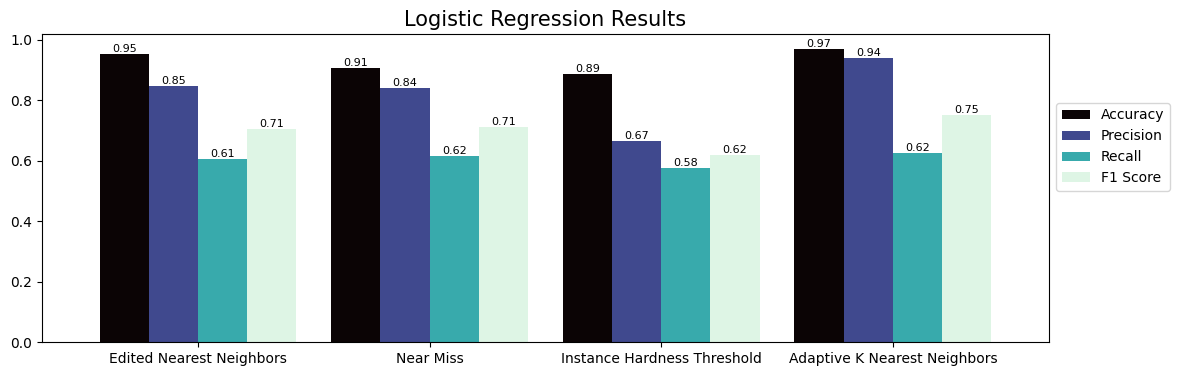

In [33]:
resplot(lrres, 'Logistic Regression Results')

In [34]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'LGR CM with {ust[n]} undersampling', cm=i)


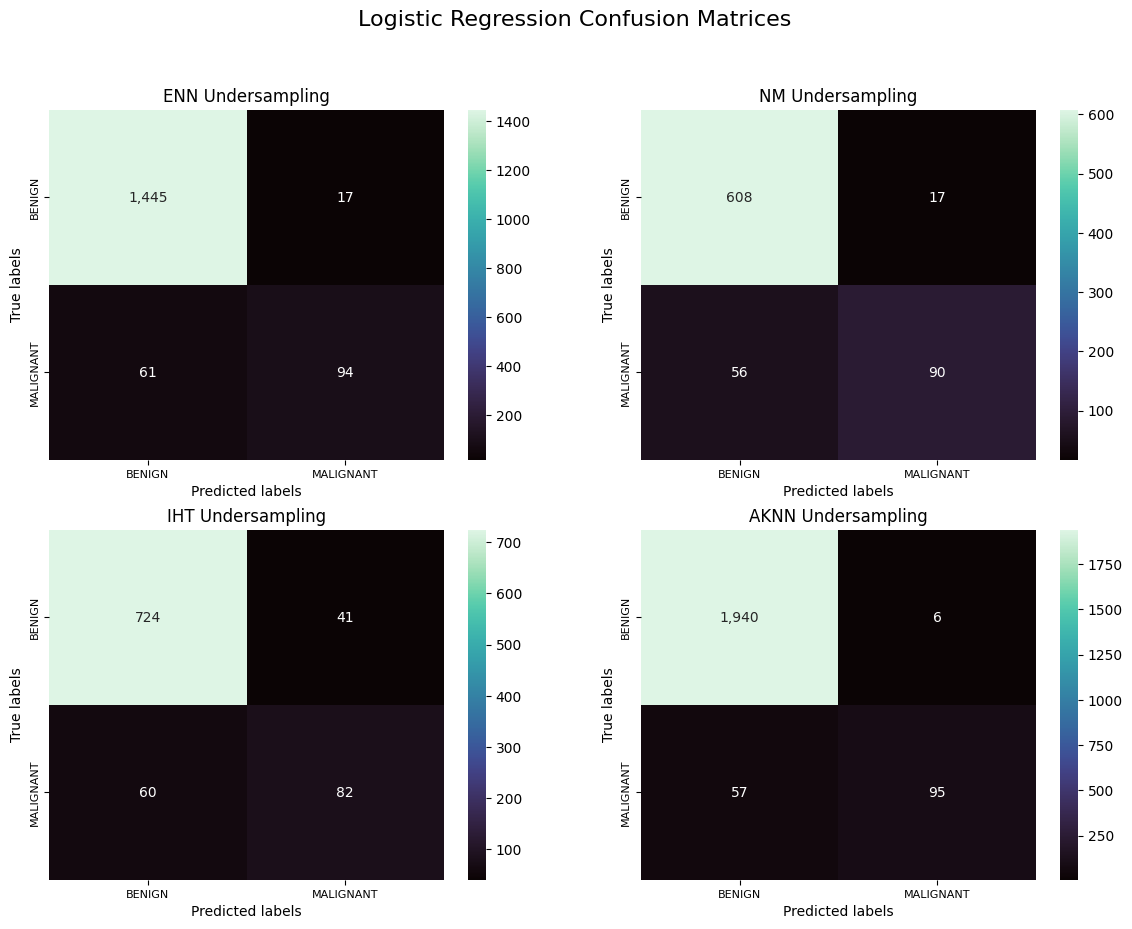

In [35]:
plot_confusion_grid(0,0, cm=cmm, t='Logistic Regression Confusion Matrices')

## Decision Tree Classifier

In [37]:
cmm=[]
dtcres=[]
clf = DecisionTreeClassifier()
for i in ust:
    clf = clf.fit(x_train[i],y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i],y_pred))
    # print(confusion_matrix(y_test[i],y_pred))
    # print(i+" Undersampling :")
    # report(y_test[i], y_pred)
    dtcres.append(report1(y_test[i], y_pred))
    # print("\n")
# print(cmm)


In [38]:
dtcres = pd.DataFrame(dtcres)
dtcres.index = ['Edited Nearest Neighbors', 'Near Miss',
               'Instance Hardness Threshold', 'Adaptive K Nearest Neighbors']
# lrres.index=['ENN', 'NM', 'IHT', 'AllKNN']
dtcres.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
dtcres

,Accuracy,Precision,Recall,F1 Score
Edited Nearest Neighbors,0.936920,0.653179,0.729032,0.689024
Near Miss,0.875486,0.678571,0.650685,0.664336
Instance Hardness Threshold,0.926130,0.773723,0.746479,0.759857
Adaptive K Nearest Neighbors,0.969495,0.797297,0.776316,0.786667


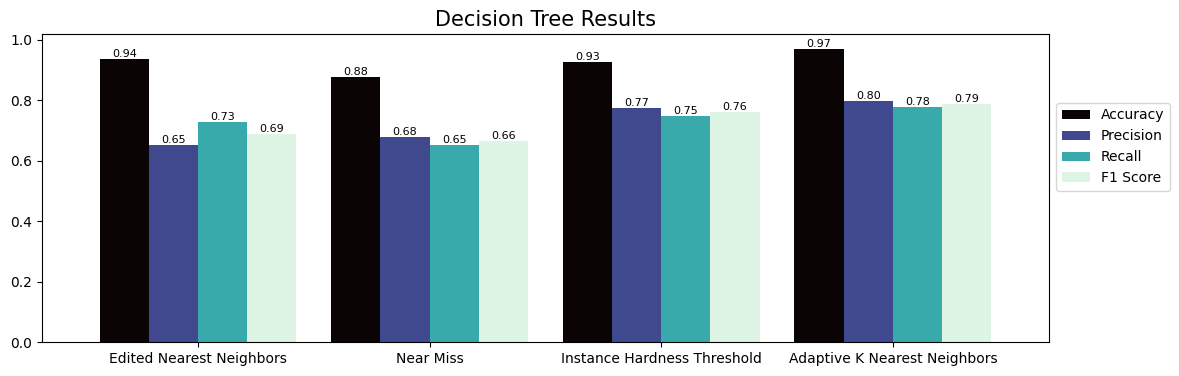

In [39]:
resplot(dtcres, 'Decision Tree Results')

In [40]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'DTC CM with {ust[n]} undersampling', cm=i)


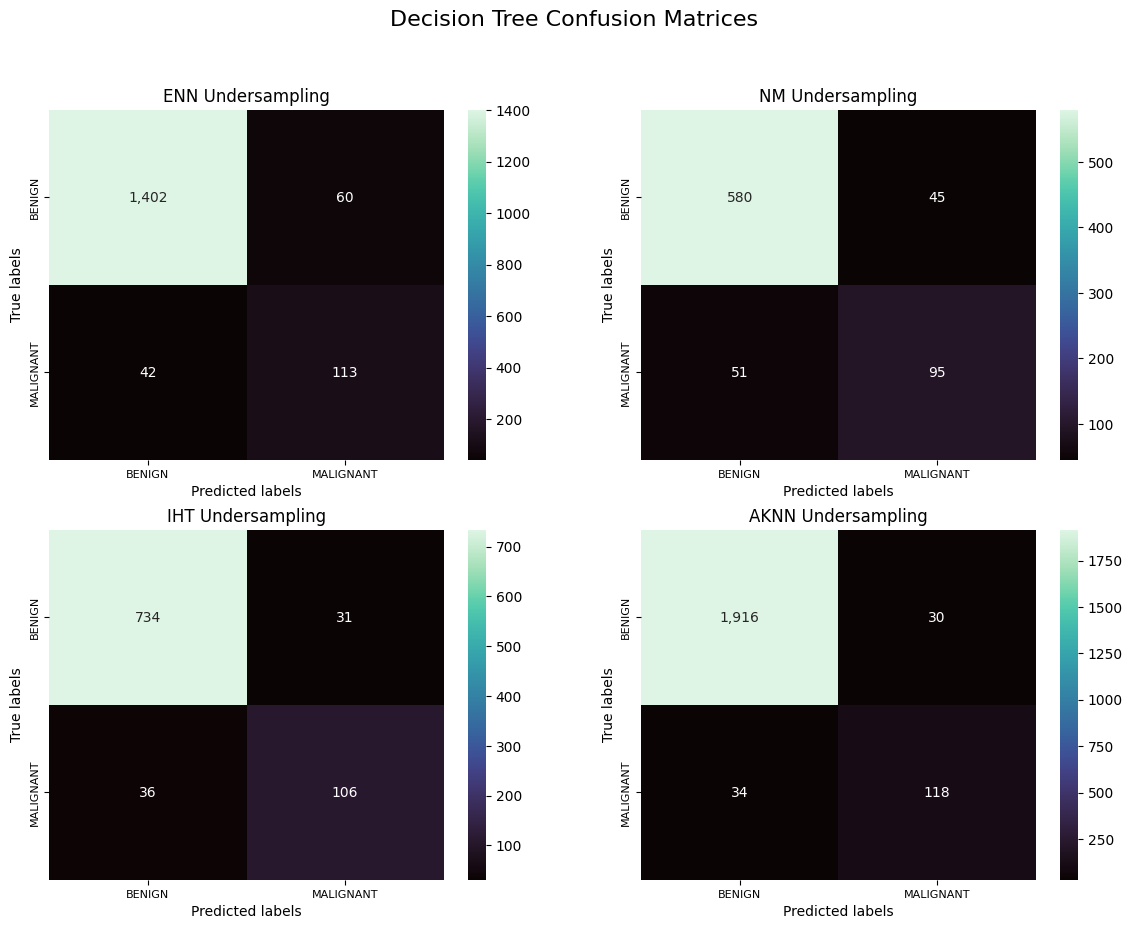

In [41]:
plot_confusion_grid(0,0, cm=cmm, t='Decision Tree Confusion Matrices')

## K Nearest Neighbors Classifier

In [42]:
clf = KNeighborsClassifier(n_neighbors=6)
cmm=[]
knnres=[]
for i in ust:
    clf = clf.fit(x_train[i],y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i],y_pred))
    # print(i+" Undersampling :")
    # report(y_test[i], y_pred)
    # print("\n\n")
    knnres.append(report1(y_test[i], y_pred))

In [43]:
knnres = pd.DataFrame(knnres)
knnres.index = ['Edited Nearest Neighbors', 'Near Miss', 'Instance Hardness Threshold', 'Adaptive K Nearest Neighbors']
knnres.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
knnres

,Accuracy,Precision,Recall,F1 Score
Edited Nearest Neighbors,0.950526,0.921348,0.529032,0.672131
Near Miss,0.892348,0.943662,0.458904,0.617512
Instance Hardness Threshold,0.896362,0.766667,0.485915,0.594828
Adaptive K Nearest Neighbors,0.971878,1.000000,0.611842,0.759184


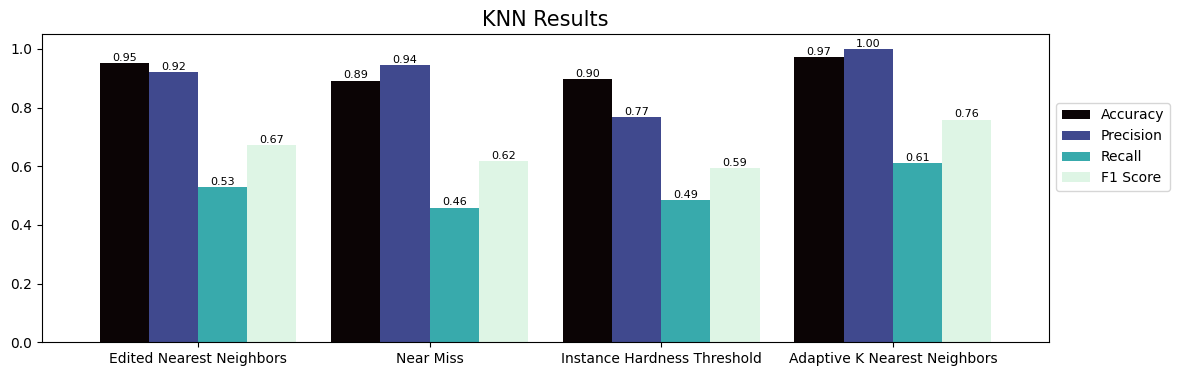

In [44]:
resplot(knnres, 'KNN Results')

In [45]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'DTC CM with {ust[n]} undersampling', cm=i)


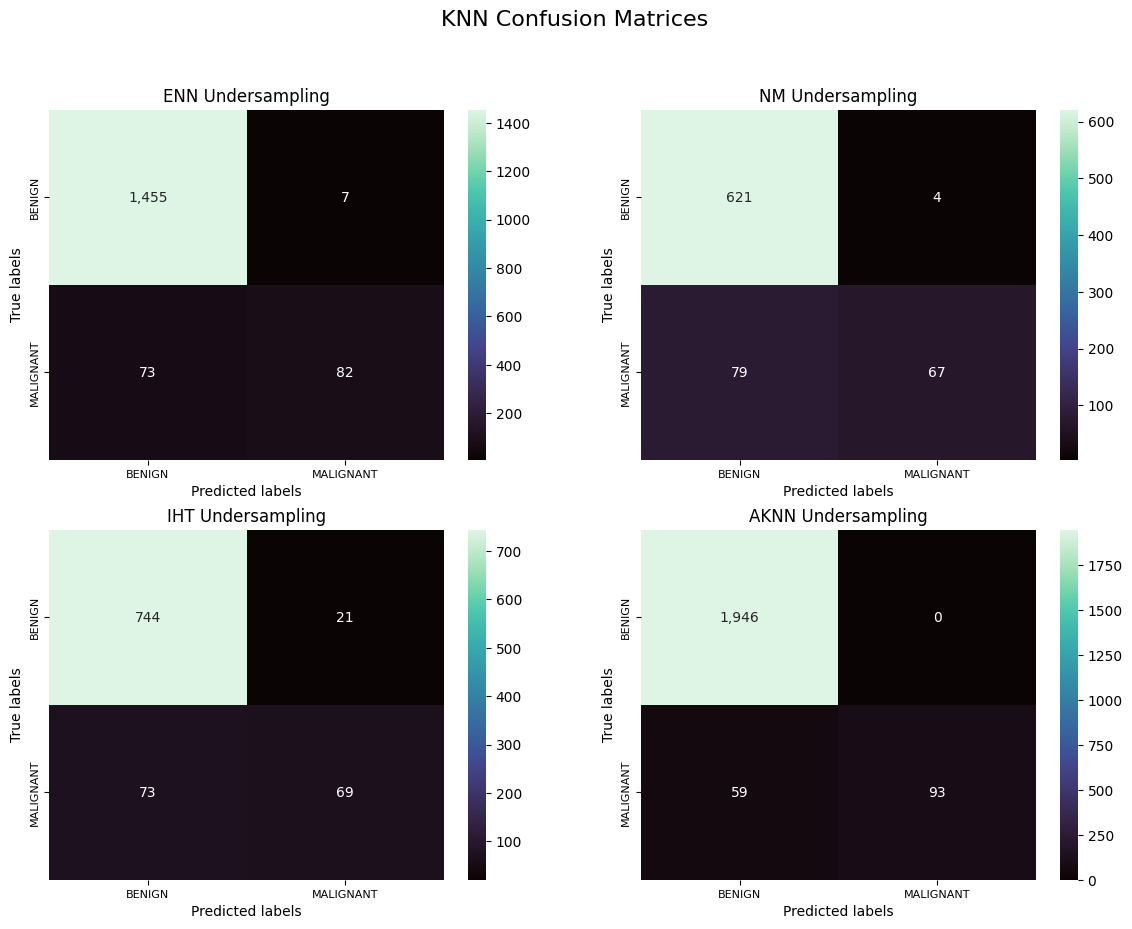

In [46]:
plot_confusion_grid(0,0, cm=cmm, t='KNN Confusion Matrices')

## Support Vector Classifier

In [47]:
cmm=[]
clf= SVC()
svmres=[]
for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    svmres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Undersampling :")
    # report(y_test[i], y_pred)
    # print("\n")

In [48]:
svmres = pd.DataFrame(svmres)
svmres.index=['Edited Nearest Neighbors', 'Near Miss', 'Instance Hardness Threshold', 'Adaptive K Nearest Neighbors']
svmres.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
svmres

,Accuracy,Precision,Recall,F1 Score
Edited Nearest Neighbors,0.959802,0.909091,0.645161,0.754717
Near Miss,0.914397,0.908163,0.609589,0.729508
Instance Hardness Threshold,0.914002,0.766667,0.647887,0.702290
Adaptive K Nearest Neighbors,0.973785,0.980198,0.651316,0.782609


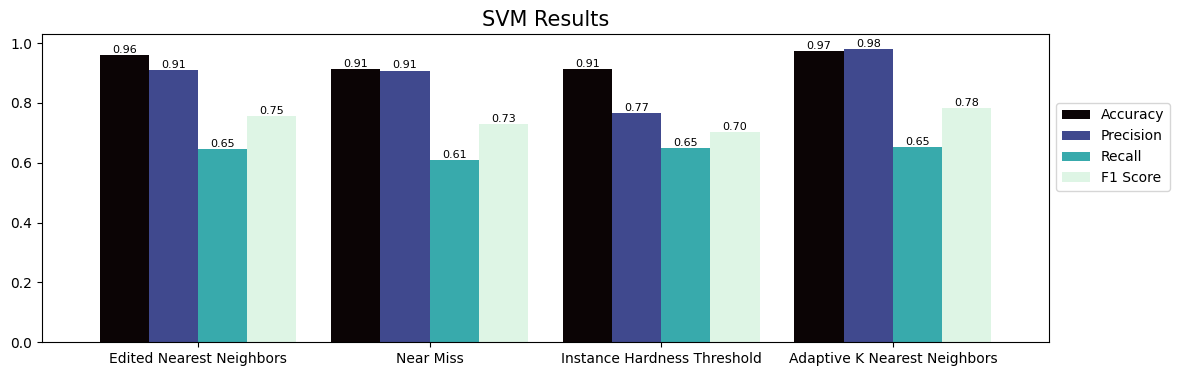

In [49]:
resplot(svmres, 'SVM Results')

In [50]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'SVM CM with {ust[n]} undersampling', cm=i)

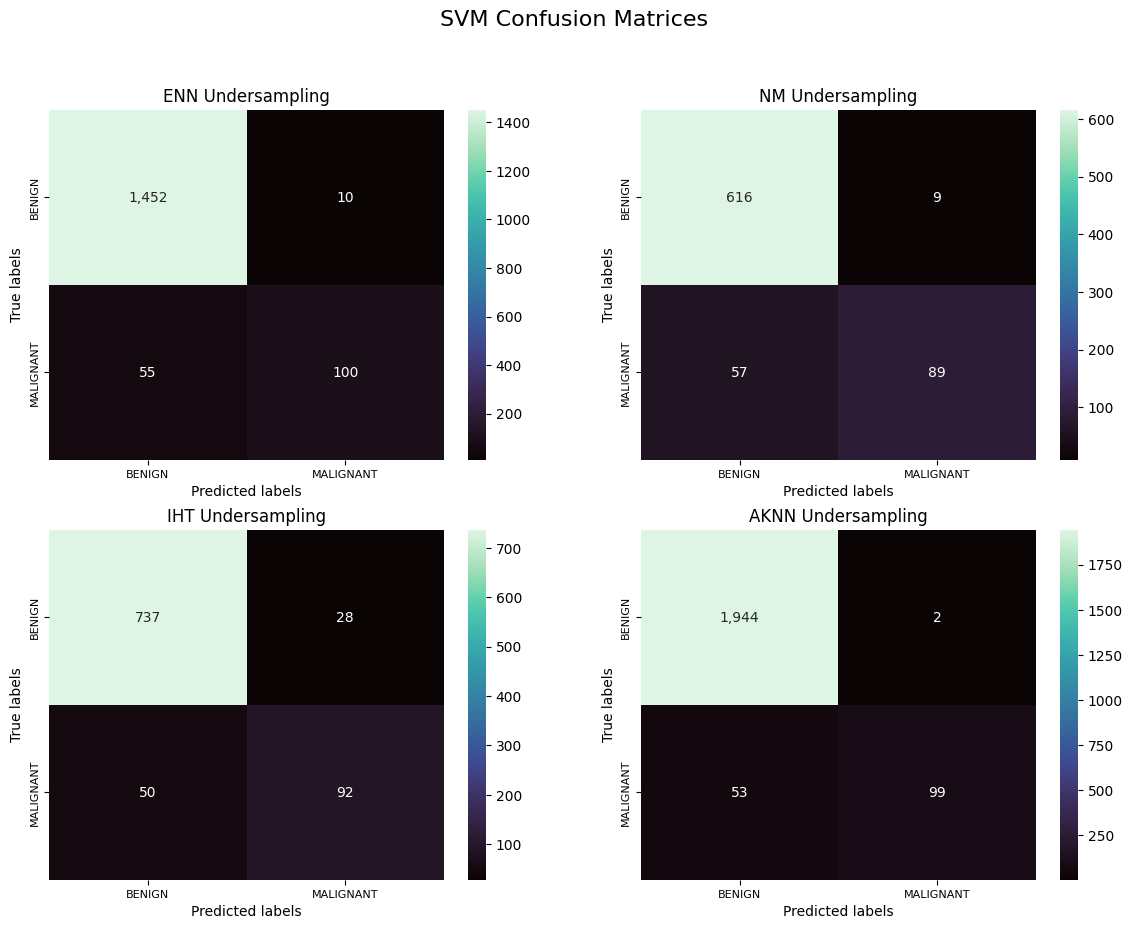

In [51]:
plot_confusion_grid(0,0, cm=cmm, t='SVM Confusion Matrices')

## Random Forest Classifier

In [52]:
cmm=[]
rfcres=[]
for i in ust:
    clf= RandomForestClassifier()
    clf=clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    rfcres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Undersampling :")
    # report(y_test[i], y_pred)
    # print("\n")
    

In [53]:
rfcres = pd.DataFrame(rfcres)
rfcres.index=['Edited Nearest Neighbors', 'Near Miss', 'Instance Hardness Threshold', 'Adaptive K Nearest Neighbors']
rfcres.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
rfcres

,Accuracy,Precision,Recall,F1 Score
Edited Nearest Neighbors,0.967223,0.932203,0.709677,0.805861
Near Miss,0.914397,0.850877,0.664384,0.746154
Instance Hardness Threshold,0.938258,0.825758,0.767606,0.795620
Adaptive K Nearest Neighbors,0.981888,0.975000,0.769737,0.860294


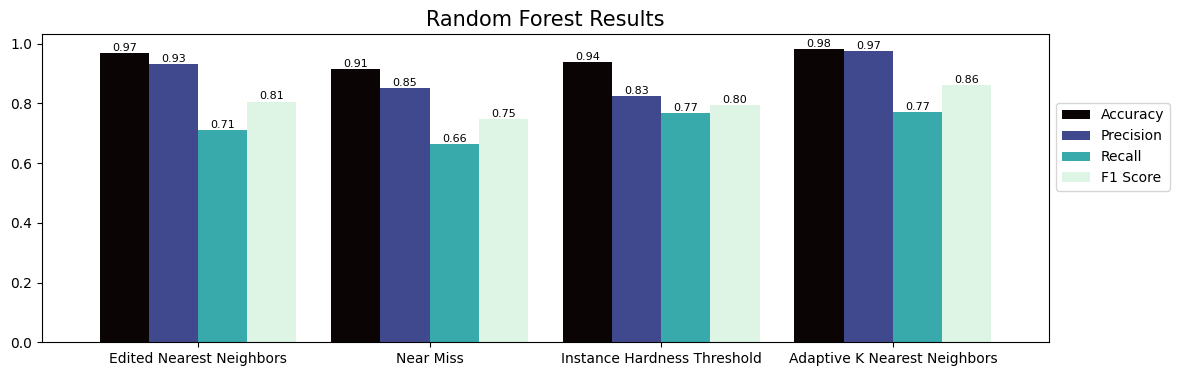

In [54]:
resplot(rfcres, 'Random Forest Results')

In [55]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'RFC CM with {ust[n]} undersampling', cm=i)
    

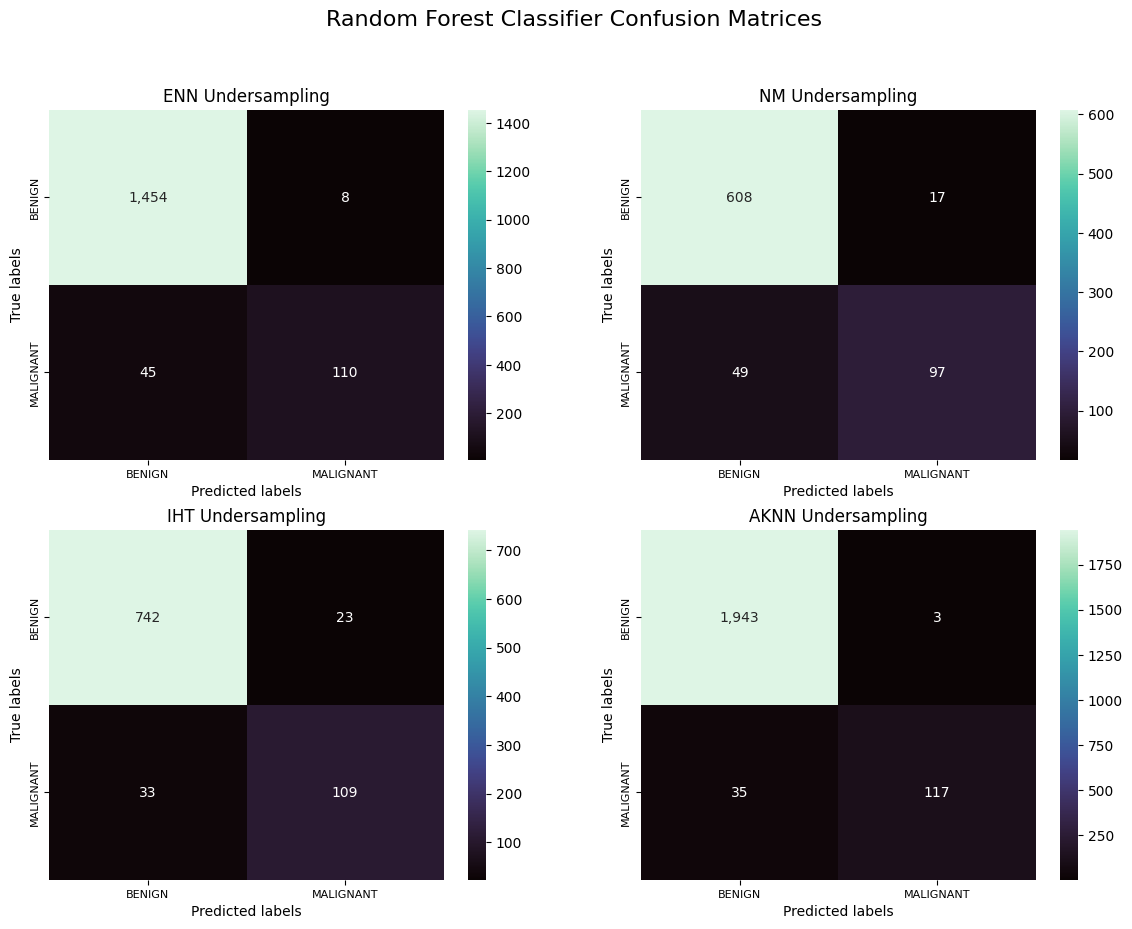

In [56]:
plot_confusion_grid(0,0, cm=cmm, t='Random Forest Classifier Confusion Matrices')

## XG Boost Classifier

In [59]:
cmm=[]
xgbres=[]
for i in ust:
    clf = XGBClassifier()
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    xgbres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Undersampling :")
    # report(y_test[i], y_pred)
    # print("\n")


In [60]:
xgbres = pd.DataFrame(xgbres)
xgbres.index=['Edited Nearest Neighbors', 'Near Miss', 'Instance Hardness Threshold', 'Adaptive K Nearest Neighbors']
xgbres.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
xgbres

,Accuracy,Precision,Recall,F1 Score
Edited Nearest Neighbors,0.966605,0.910569,0.722581,0.805755
Near Miss,0.909209,0.827586,0.657534,0.732824
Instance Hardness Threshold,0.944873,0.865079,0.767606,0.813433
Adaptive K Nearest Neighbors,0.986177,0.992000,0.815789,0.895307


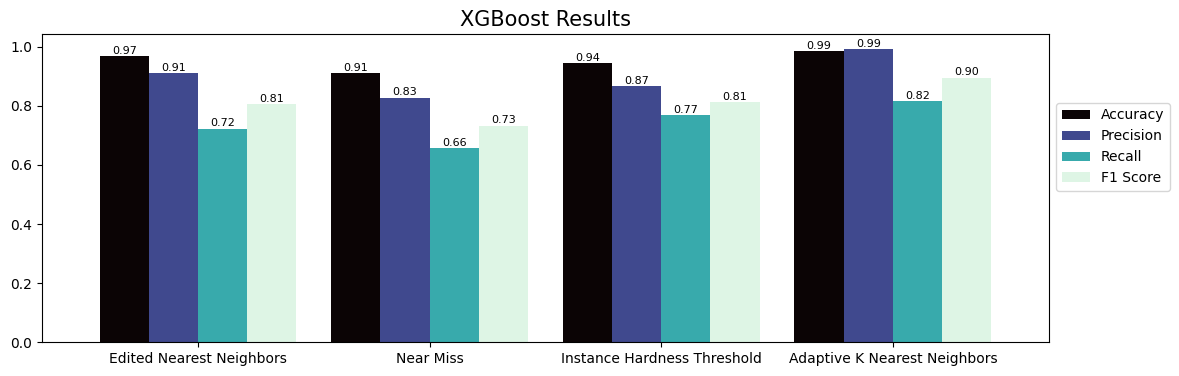

In [61]:
resplot(xgbres, 'XGBoost Results')

In [62]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'XGBC CM with {ust[n]} undersampling', cm=i)


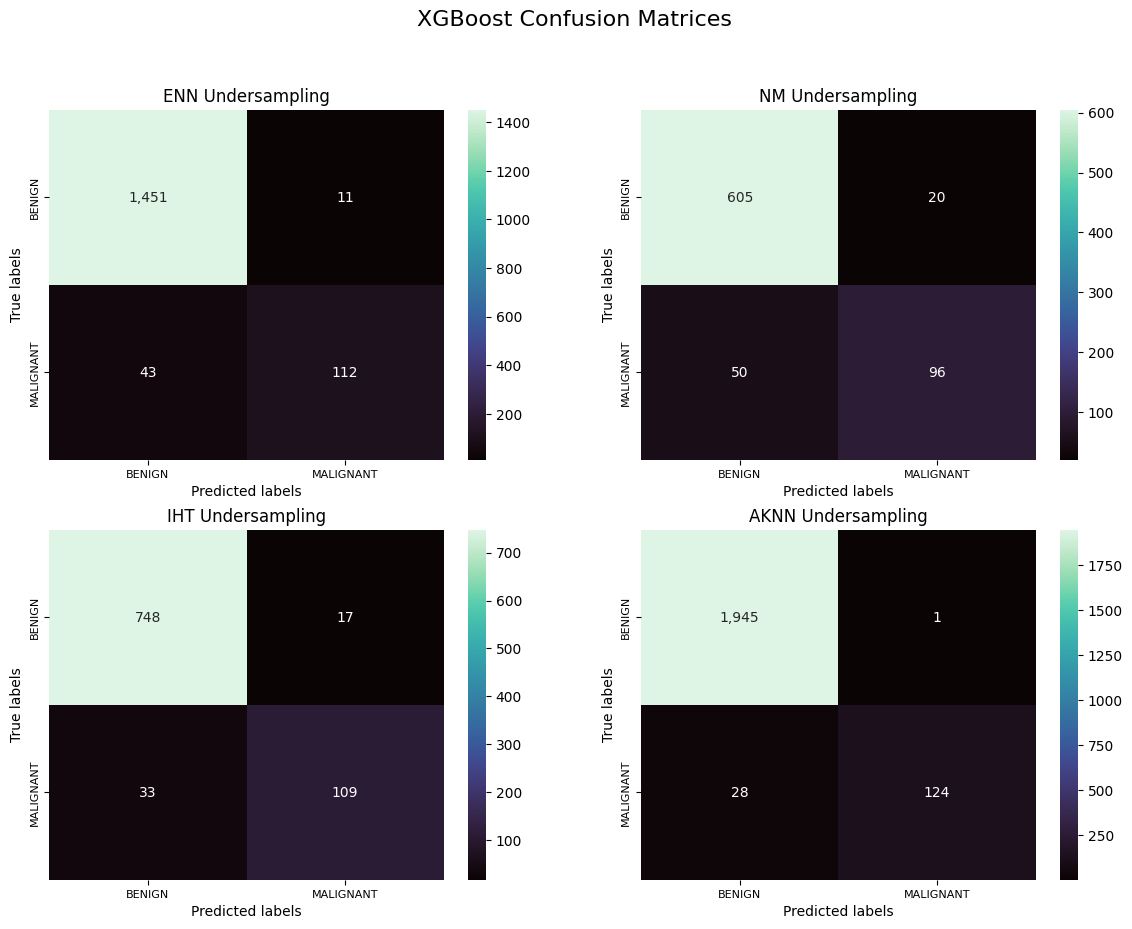

In [63]:
plot_confusion_grid(0,0, cm=cmm, t='XGBoost Confusion Matrices')

## Light GBM Classifier

In [64]:
cmm=[]
lgbmres=[]
clf = LGBMClassifier(learning_rate=0.3, n_estimators=100, num_leaves=100, random_state=42)

for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    lgbmres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Undersampling :")
    # report(y_test[i], y_pred)
    # print("\n")


In [65]:
lgbmres = pd.DataFrame(lgbmres)
lgbmres.index=['Edited Nearest Neighbors', 'Near Miss', 'Instance Hardness Threshold', 'Adaptive K Nearest Neighbors']
lgbmres.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
lgbmres

,Accuracy,Precision,Recall,F1 Score
Edited Nearest Neighbors,0.965368,0.915966,0.703226,0.795620
Near Miss,0.909209,0.833333,0.650685,0.730769
Instance Hardness Threshold,0.937155,0.824427,0.760563,0.791209
Adaptive K Nearest Neighbors,0.983317,0.983471,0.782895,0.871795


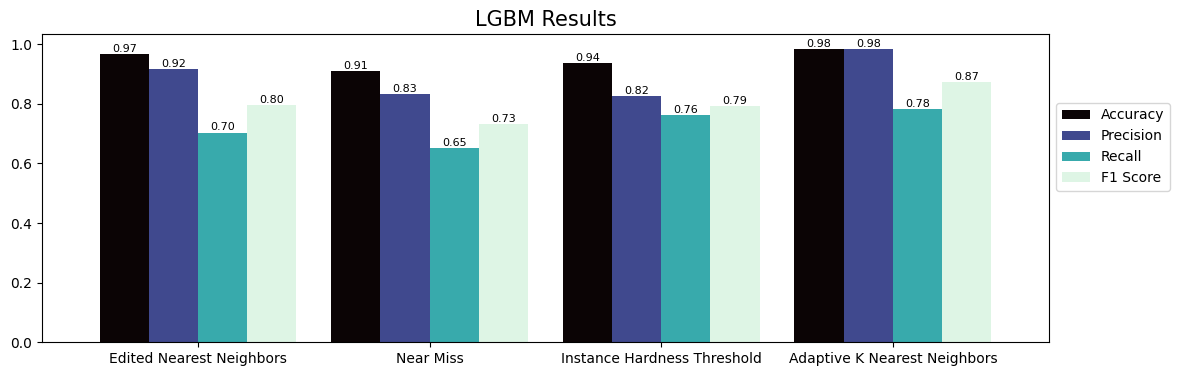

In [66]:
resplot(lgbmres, 'LGBM Results')

In [67]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'LGBM CM with {ust[n]} undersampling', cm=i)


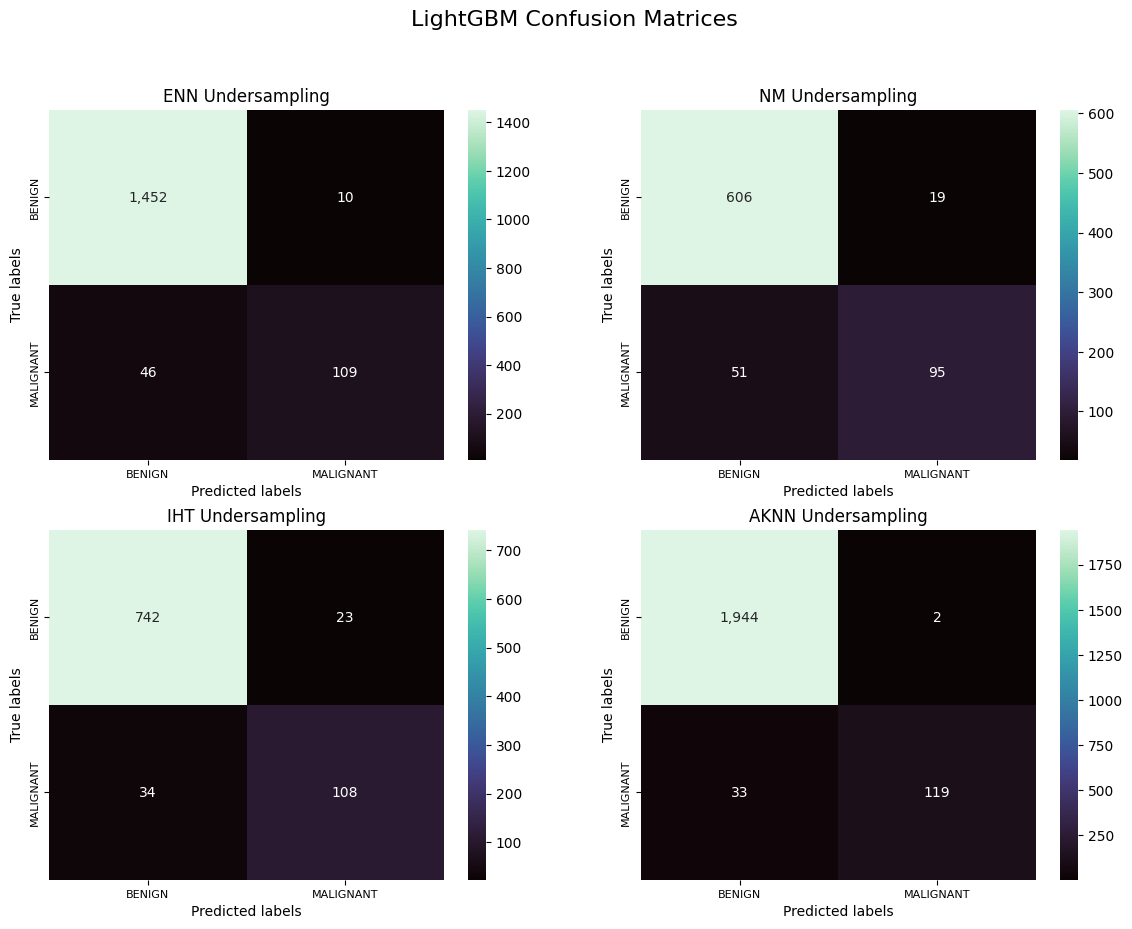

In [68]:
plot_confusion_grid(0,0, cm=cmm, t='LightGBM Confusion Matrices')

## AdaBoost Classifier

In [69]:
cmm = []
adares = []
clf = AdaBoostClassifier(n_estimators=100, random_state=42)
for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    adares.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Undersampling :")
    # report(y_test[i], y_pred)
    # print("\n")


In [70]:
adares = pd.DataFrame(adares)
adares.index=['Edited Nearest Neighbors', 'Near Miss', 'Instance Hardness Threshold', 'Adaptive K Nearest Neighbors']
adares.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
adares

,Accuracy,Precision,Recall,F1 Score
Edited Nearest Neighbors,0.959184,0.850394,0.696774,0.765957
Near Miss,0.905318,0.828829,0.630137,0.715953
Instance Hardness Threshold,0.909592,0.734375,0.661972,0.696296
Adaptive K Nearest Neighbors,0.981411,0.924812,0.809211,0.863158


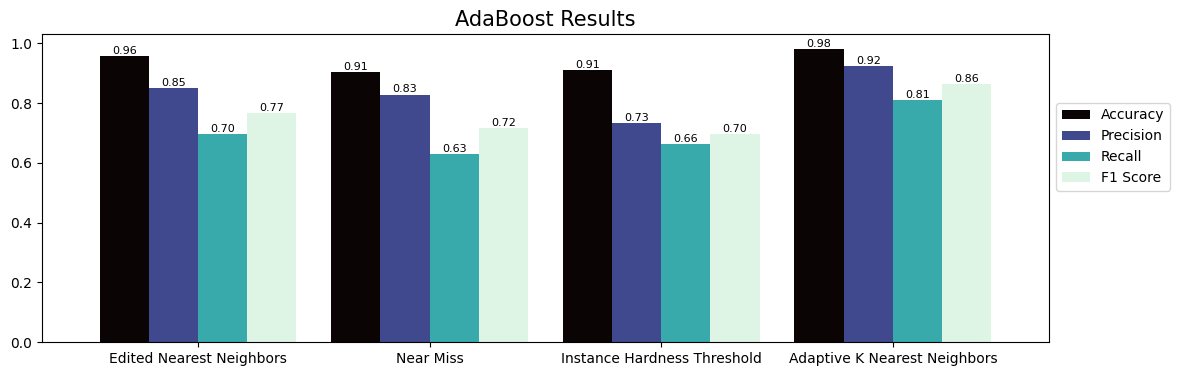

In [71]:
resplot(adares, 'AdaBoost Results')

In [72]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'AdaBoost CM with {ust[n]} undersampling', cm=i)

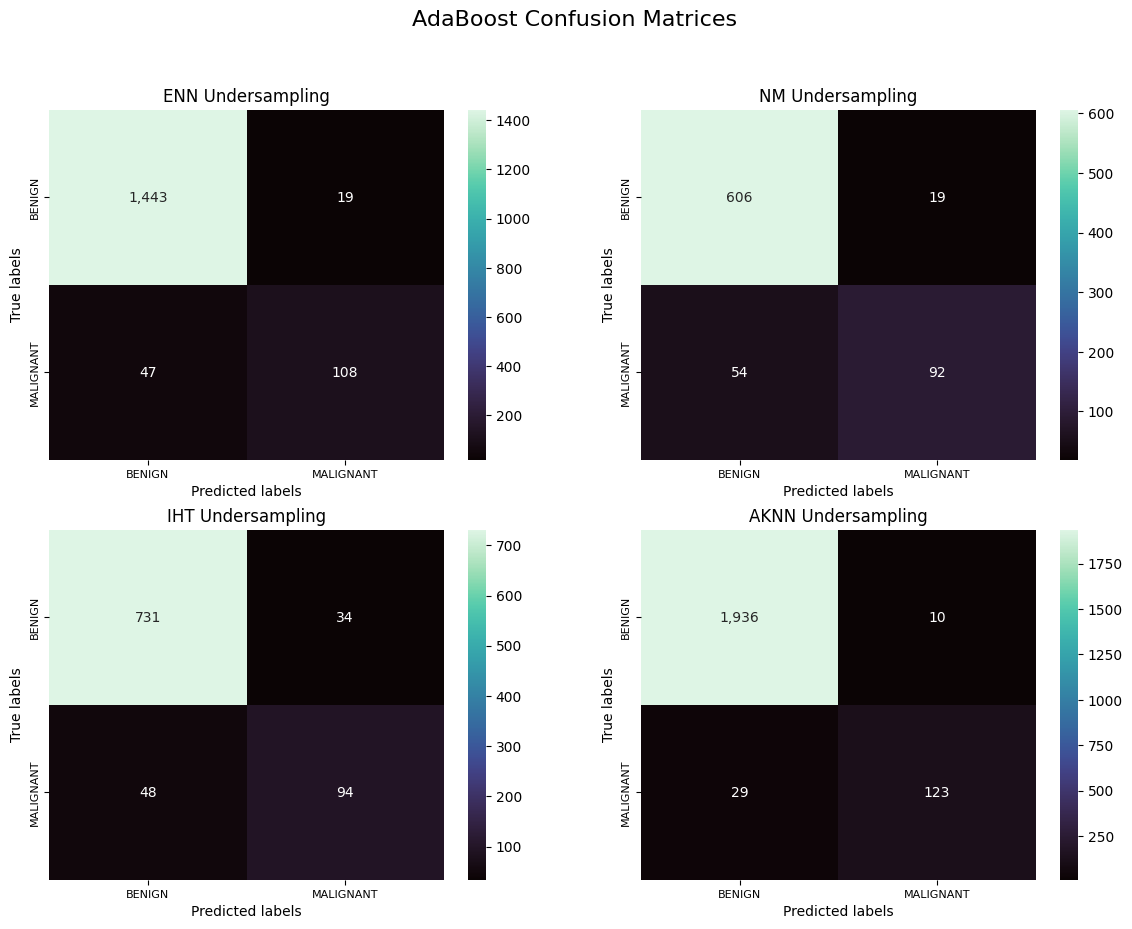

In [73]:
plot_confusion_grid(0,0, cm=cmm, t='AdaBoost Confusion Matrices')

We can see that Adaboost Classifier performs best with ```ALLKNN Undersampling``` technique, having an F1 score of ```0.86```.

## CatBoost Classifier

In [74]:
cmm=[]
# drep={}
cbcres=[]
clf= CBC()
for i in ust :
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    cbcres.append(report1(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    # print(i+" Undersampling :")
    # drep[i]= report(y_test[i], y_pred)
    # print("\n")


Learning rate set to 0.020218
0:	learn: 0.6612961	total: 160ms	remaining: 2m 39s
1:	learn: 0.6299840	total: 166ms	remaining: 1m 22s
2:	learn: 0.6018618	total: 173ms	remaining: 57.6s
3:	learn: 0.5742827	total: 183ms	remaining: 45.5s
4:	learn: 0.5463620	total: 191ms	remaining: 37.9s
5:	learn: 0.5229314	total: 198ms	remaining: 32.8s
6:	learn: 0.4984512	total: 205ms	remaining: 29.1s
7:	learn: 0.4756472	total: 216ms	remaining: 26.7s
8:	learn: 0.4586639	total: 224ms	remaining: 24.6s
9:	learn: 0.4378626	total: 232ms	remaining: 22.9s
10:	learn: 0.4212416	total: 239ms	remaining: 21.5s
11:	learn: 0.4033171	total: 245ms	remaining: 20.2s
12:	learn: 0.3853025	total: 252ms	remaining: 19.1s
13:	learn: 0.3720915	total: 259ms	remaining: 18.2s
14:	learn: 0.3591462	total: 266ms	remaining: 17.4s
15:	learn: 0.3465640	total: 273ms	remaining: 16.8s
16:	learn: 0.3331568	total: 280ms	remaining: 16.2s
17:	learn: 0.3213923	total: 289ms	remaining: 15.8s
18:	learn: 0.3091605	total: 296ms	remaining: 15.3s
19:	learn

In [75]:
cbcres = pd.DataFrame(cbcres)
cbcres.index=['Edited Nearest Neighbors', 'Near Miss', 'Instance Hardness Threshold', 'Adaptive K Nearest Neighbors']
cbcres.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
cbcres

,Accuracy,Precision,Recall,F1 Score
Edited Nearest Neighbors,0.969697,0.934426,0.735484,0.823105
Near Miss,0.915694,0.871560,0.650685,0.745098
Instance Hardness Threshold,0.937155,0.824427,0.760563,0.791209
Adaptive K Nearest Neighbors,0.984747,0.991803,0.796053,0.883212


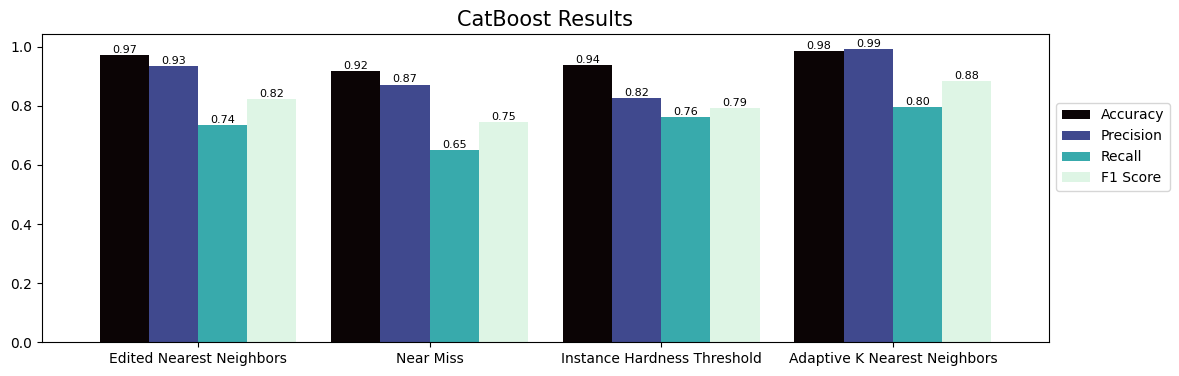

In [76]:
resplot(cbcres, 'CatBoost Results')

In [77]:
# for n, i in enumerate(cmm):
#     plot_confusion_matrix(0, 0, t=f'CatBoost CM with {ust[n]} undersampling', cm=i)

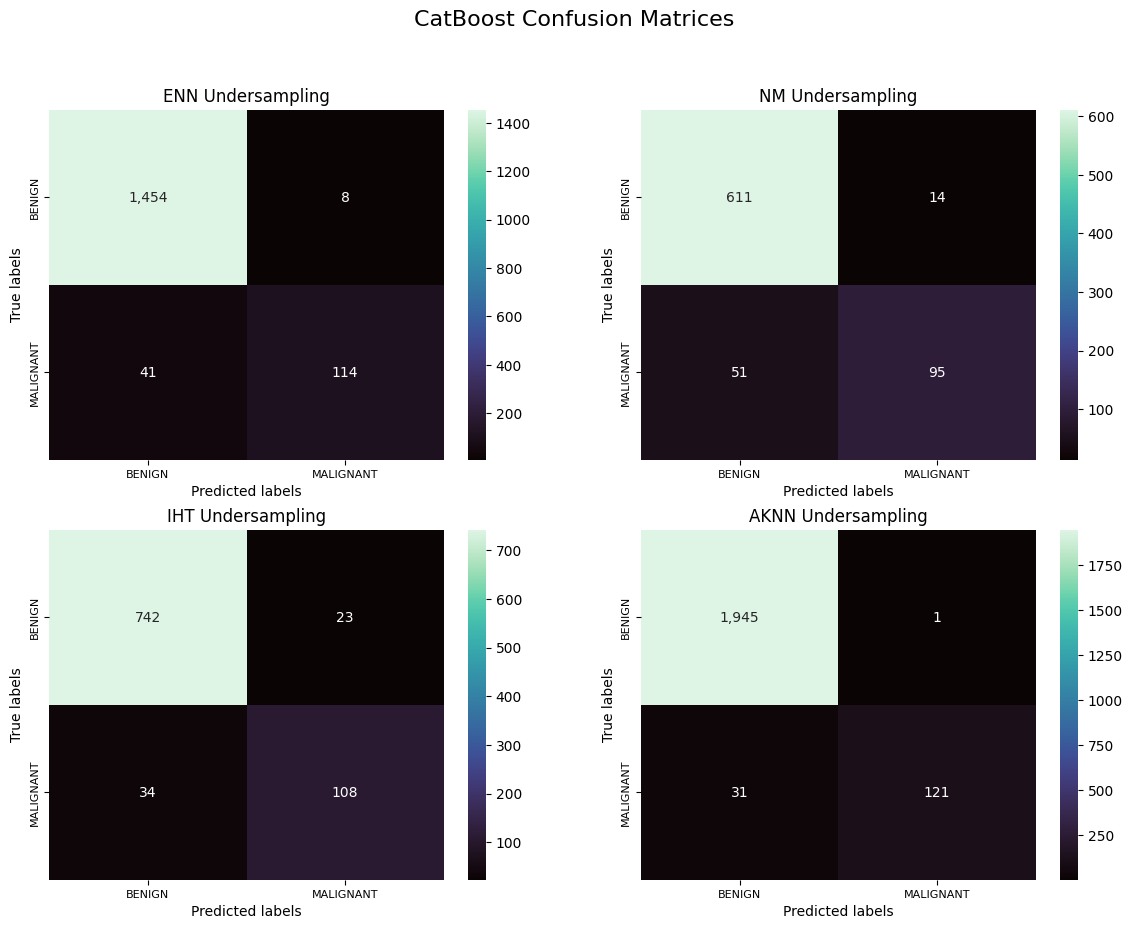

In [78]:
plot_confusion_grid(0,0, cm=cmm, t='CatBoost Confusion Matrices')

# Conclusions:
Based on the above results, we can conclude that:
1. Though the undersampling using AllKNN and ENN techniques have more samples, the F1 score is greater than that of NearMiss and IHT techniques.
2. Also the models performed way better on the The AllKNN and ENN techiques than the other two techniques.
3. IHT undersampling also had some decent scores for some models but was largely inconsistent.
4. Most models performed good, because the dataset was reduced. 
5. Particularly, boosting algorithms performed very well on the undersampled data, producing >0.8 F1 scores.
